In [2]:
#Configuro el Google Colab conectandome a los datos desde la cuenta de Google
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from itertools import product
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

# Preparación de los datos

In [4]:
#1. Carga del Dataset
####CODIGO INICIAL#####
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Proyecto_integradorA/all_files_E.csv')

#2. Estandarizacion de columna mfr empleando diccionario

## Diccionario de mapeo de valores originales a valores deseados
mapeo = {
  'Ansal' : 'ANS',
  'General Electric' : 'GE',
  'Brown Boveri Company' : 'GMX',
  'Mitsubishi' : 'MIT',
  'ENERGOMEX' : 'ENG',
  'Rade-Koncar' : 'RK',
  'Toshiba' : 'TOS',
  'AEG Power Tool Corp.' : 'GMX',
  'Alstom' : 'ALS',
  'ASEA' : 'GMX',
  'RADE KONCAR' : 'RK',
  'Westinghouse Electric' : 'OTH',
  'TIBB' : 'GMX',
  'ABB (ASEA-Brown Boveri)' : 'GMX',
  'Koch & Sterzel' : 'OTH',
  'Hitachi' : 'HIT',
  'ASEA Inc.' : 'GMX',
  'Cenemesa' : 'OTH',
  'HITACHI' : 'HIT',
  'Raychem' : 'OTH',
  'Brush Ltd. (H-S Group)' : 'OTH',
  'HARBIN ELECTRIC MACHINERY' : 'OTH',
  'Magnetek' : 'OTH',
  'GAMESA' : 'OTH'
}

## Cambiar los valores en la columna 'mfr' utilizando el diccionario
df['mfr'] = df['mfr'].map(mapeo)

#3. Homologar valores de columna group_number
## Reemplazar los valores en la columna group_number
df['group_number'] = df['group_number'].replace({0: 'GST', 1: 'GST', 2: 'GST', 6:'GST', 3: 'UST', 4: 'UST', 5: 'UST'})

#4. Estandarizacion de valores para columna requested_text_kv (rtkv)

## Obtener los valores únicos de la columna 'requested_test_kv'
valores_rtkv = df['requested_test_kv'].unique()
#Reemplazo de valores
## Diccionario de reemplazo
diccionario_reemplazo = {
    2.5: 2.,
    2.3: 2.,
    2.4: 2.,
    3.8: 4.,
    10.4: 10.,
    10.0: 10.,
    5.9: 6.,
    6.1: 6.,
    8.1: 8.,
    8.2: 8.,
    1.9: 2.,
    7.9: 8.,
    2.1: 2.,
    9.9: 10.,
    10.3: 10.,
    10.2: 10.,
    10.4: 10.
}
df.loc[:, 'requested_test_kv'] = df['requested_test_kv'].replace(diccionario_reemplazo)

## Registros a depurar basados en la columna 'requested_test_kv' por ser no válidos para el análisis
valores_a_eliminar = [0.2, 0.5, 1.4, 1.5, 0.8, 0.1, 5.5, 7, 9 ]

## Eliminar filas con los valores especificados
df = df[~df['requested_test_kv'].isin(valores_a_eliminar)]

## Obtener los valores únicos de la columna 'requested_test_kv'
valores_rtkv = df['requested_test_kv'].unique()
valores_rtkv

#5. Eliminacion valores no válidos (0, NaN, NULL, etc)
## Contar la cantidad de NaN en df
#cantidad_nan = df.isna().sum()
#print(f"Cantidad de NaN en {'df'}: {cantidad_nan}")

columna_filtrar = 'ma'
df = df[(df[columna_filtrar] != 0) & (~df[columna_filtrar].isna())]
columna_filtrar = 'measured_cap'
df = df[(df[columna_filtrar] != 0) & (~df[columna_filtrar].isna())]
columna_filtrar = 'pfm'
df = df[(df[columna_filtrar] != 0) & (~df[columna_filtrar].isna())]

## Contar la cantidad de NaN en df
#cantidad_nan = df.isna().sum()
#print(f"Cantidad de NaN en {'df'}: {cantidad_nan}")
df.to_csv('datafiles_clean.csv')
df= df[((df['stator_kv'] == 6.9) | (df['stator_kv'] == 13.8)|(df['stator_kv'] == 18.))]

In [5]:
df

Unnamed: 0    serial  mfr                fecha  requested_test_kv  \
0               0    715015  TOS  2018-11-27 16:07:37                2.0   
1               1    715015  TOS  2018-11-27 16:07:37                4.0   
2               2    715015  TOS  2018-11-27 16:07:37                6.0   
3               3    715015  TOS  2018-11-27 16:07:37                8.0   
4               4    715015  TOS  2018-11-27 16:07:37                2.0   
...           ...       ...  ...                  ...                ...   
17349       17349  82EU7701  ALS  2005-10-01 17:29:11                8.0   
17350       17350  82EU7701  ALS  2005-10-01 17:29:11                2.0   
17351       17351  82EU7701  ALS  2005-10-01 17:29:11                4.0   
17352       17352  82EU7701  ALS  2005-10-01 17:29:11                6.0   
17353       17353  82EU7701  ALS  2005-10-01 17:29:11                8.0   

        test_kv           ma       watts   measured_cap       pfm  pfm_tipup  \
0      1.994720  3572.892785  388.191193  948070.805862  1.086490        NaN   
1      4.015733  3583.967686  458.960388  950296.254132  1.280593   0.194103   
2      5.990353  3568.703294  517.651520  947210.963886  1.450531   0.364041   
3      8.009873  3599.445462  585.986572  954618.258220  1.627991   0.541501   
4      2.000625  3562.023163  385.123230  945508.958239  1.081192        NaN   
...         ...          ...         ...            ...       ...        ...   
17349  8.010000    12.515000    2.505000    3318.600000  2.000000        NaN   
17350  2.001000    11.261000    2.216000    2988.400000  1.970000        NaN   
17351  4.001000    11.285000    2.141000    2994.200000  1.900000        NaN   
17352  5.998000    11.294000    2.207000    2996.400000  1.950000        NaN   
17353  7.997000    11.300000    2.274000    2998.400000  2.010000        NaN   

       line_id group_number      circuit      location         division  \
0          1.0          GST  CIRC_GND_RB     PORCE III  GUADALUPE PORCE   
1          2.0          GST  CIRC_GND_RB     PORCE III  GUADALUPE PORCE   
2          3.0          GST  CIRC_GND_RB     PORCE III  GUADALUPE PORCE   
3          4.0          GST  CIRC_GND_RB     PORCE III  GUADALUPE PORCE   
4          5.0          GST  CIRC_GND_RB     PORCE III  GUADALUPE PORCE   
...        ...          ...          ...           ...              ...   
17349     36.0          UST    Undefined  GUADALUPE IV        GUADALUPE   
17350     41.0          UST    Undefined  GUADALUPE IV        GUADALUPE   
17351     42.0          UST    Undefined  GUADALUPE IV        GUADALUPE   
17352     43.0          UST    Undefined  GUADALUPE IV        GUADALUPE   
17353     44.0          UST    Undefined  GUADALUPE IV        GUADALUPE   

                                 company cct_designation  stator_kv  
0      EMPRESAS PUBLICAS DE MEDELLIN EPM        UNIDAD 3       13.8  
1      EMPRESAS PUBLICAS DE MEDELLIN EPM        UNIDAD 3       13.8  
2      EMPRESAS PUBLICAS DE MEDELLIN EPM        UNIDAD 3       13.8  
3      EMPRESAS PUBLICAS DE MEDELLIN EPM        UNIDAD 3       13.8  
4      EMPRESAS PUBLICAS DE MEDELLIN EPM        UNIDAD 3       13.8  
...                                  ...             ...        ...  
17349                              EEPPM        UNIDAD 1       13.8  
17350                              EEPPM        UNIDAD 1       13.8  
17351                              EEPPM        UNIDAD 1       13.8  
17352                              EEPPM        UNIDAD 1       13.8  
17353                              EEPPM        UNIDAD 1       13.8  

[15527 rows x 19 columns]

# Ejercicios de Clusterización (1)

In [6]:
# Obtener el array de los valores sin repetidos
array_valores_no_repetidos = list(set(mapeo.values()))

# Imprimir el array de los valores
print(array_valores_no_repetidos)

['RK', 'OTH', 'ENG', 'TOS', 'ALS', 'ANS', 'MIT', 'GMX', 'HIT', 'GE']


In [7]:
# Definir los arrays
array_a = ['GST', 'UST']
array_b = [6.9, 13.8, 18]
array_c = array_valores_no_repetidos
array_d = [1,2,3,4,6,8,10]

# Obtener todas las combinaciones posibles
combinaciones = list(product(array_a, array_b, array_c,array_d))

 # Mostrar el tamaño de la lista
print("Tamaño de la lista de combinaciones:", len(combinaciones))
combinaciones
# Imprimir las combinaciones
#print(combinaciones)

Tamaño de la lista de combinaciones: 420


[('GST', 6.9, 'RK', 1),
 ('GST', 6.9, 'RK', 2),
 ('GST', 6.9, 'RK', 3),
 ('GST', 6.9, 'RK', 4),
 ('GST', 6.9, 'RK', 6),
 ('GST', 6.9, 'RK', 8),
 ('GST', 6.9, 'RK', 10),
 ('GST', 6.9, 'OTH', 1),
 ('GST', 6.9, 'OTH', 2),
 ('GST', 6.9, 'OTH', 3),
 ('GST', 6.9, 'OTH', 4),
 ('GST', 6.9, 'OTH', 6),
 ('GST', 6.9, 'OTH', 8),
 ('GST', 6.9, 'OTH', 10),
 ('GST', 6.9, 'ENG', 1),
 ('GST', 6.9, 'ENG', 2),
 ('GST', 6.9, 'ENG', 3),
 ('GST', 6.9, 'ENG', 4),
 ('GST', 6.9, 'ENG', 6),
 ('GST', 6.9, 'ENG', 8),
 ('GST', 6.9, 'ENG', 10),
 ('GST', 6.9, 'TOS', 1),
 ('GST', 6.9, 'TOS', 2),
 ('GST', 6.9, 'TOS', 3),
 ('GST', 6.9, 'TOS', 4),
 ('GST', 6.9, 'TOS', 6),
 ('GST', 6.9, 'TOS', 8),
 ('GST', 6.9, 'TOS', 10),
 ('GST', 6.9, 'ALS', 1),
 ('GST', 6.9, 'ALS', 2),
 ('GST', 6.9, 'ALS', 3),
 ('GST', 6.9, 'ALS', 4),
 ('GST', 6.9, 'ALS', 6),
 ('GST', 6.9, 'ALS', 8),
 ('GST', 6.9, 'ALS', 10),
 ('GST', 6.9, 'ANS', 1),
 ('GST', 6.9, 'ANS', 2),
 ('GST', 6.9, 'ANS', 3),
 ('GST', 6.9, 'ANS', 4),
 ('GST', 6.9, 'ANS', 6),
 (

In [8]:
def obtener_datos_por_combinacion(_df, combinacion):
    # Filtrar el DataFrame según la combinación actual
    filtro = (_df['group_number'] == combinacion[0]) & \
             (_df['stator_kv'] == combinacion[1]) & \
             (_df['mfr'] == combinacion[2])

    datos_filtrados = _df[filtro]

    # Crear un objeto con la estructura deseada
    objeto = {
        "family": f"{combinacion[0]}_{combinacion[1]}_{combinacion[2]}_{combinacion[3]}",
        "df": datos_filtrados.to_dict(orient='records')  # Convertir DataFrame a lista de diccionarios
    }

    return objeto


In [9]:
def filtrar_objetos_con_datos(array_objetos):
    # Array para guardar los objetos filtrados
    objetos_filtrados = []

    # Iterar a través de cada objeto en el array
    for objeto in array_objetos:
        # Verificar si el campo 'df' del objeto tiene longitud mayor a 0
        if len(objeto['df']) > 0:
            # Agregar el objeto al array de objetos filtrados
            objetos_filtrados.append(objeto)

    # Retornar el array de objetos filtrados
    return objetos_filtrados

In [10]:

# Crear una lista de objetos con los datos filtrados
objetos_datos = [obtener_datos_por_combinacion(df, combinacion) for combinacion in combinaciones]

print("Tamaño de la lista de objetos_datos:", len(objetos_datos))

# Imprimir la lista de objetos
# Obtener el DataFrame del primer objeto en la lista
#df_del_primer_objeto = pd.DataFrame(objetos_datos[0]["df"])
#df_del_primer_objeto

Tamaño de la lista de objetos_datos: 420


In [11]:
#
resultados_filtrados = filtrar_objetos_con_datos(objetos_datos)

In [12]:
#resultados_filtrados[0]
print("Tamaño de la lista de objetos_datos:", len(resultados_filtrados))

Tamaño de la lista de objetos_datos: 182


# **Evaluación PCA**

*   En este caso, el tratamiento de datos empleando PCA nos permite identificar las variables que mayor incidencia tienen en el set de datos; se puede identificar una alta colinealidad entre las variables 'ma', 'watts' y 'measured_cap', dadas las cercanías en sus coeficientes; El método tradicional emplea siempre evaluar 'pfm' vs 'requested_test_kv', y se observa que si bien los pesos son bajos, no hay una colinealidad.
*   Las componentes principales se construyen para ser ortogonales entre sí, lo que significa que no están correlacionadas. Sin embargo, cuando se interpreta la importancia relativa de las variables en una componente principal, la presencia de pesos similares para múltiples variables puede indicar la existencia de patrones o estructuras subyacentes en los datos.
*   La matriz de correlacion permite llegar a la misma conclusión.
*   De acuerdo con las prácticas de industria se decide contiuar con la evalaucion entre variables 'requested_test_kv' y 'pfm'.

# **Modelo 1 - Clasificación No supervisada - k-Means**

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def realizar_clustering(Y, random_state=42):
    # Convertir la lista de diccionarios en un DataFrame de Pandas
    Y = pd.DataFrame(Y)
    # Seleccionar columnas
    Y = Y[['test_kv', 'ma']]

    # Dividir los datos en conjuntos de entrenamiento, validación y prueba
    Y_train, Y_temp, _, _ = train_test_split(Y, Y, test_size=0.3, random_state=random_state)
    Y_val, Y_test, _, _ = train_test_split(Y_temp, Y_temp, test_size=0.5, random_state=random_state)

    # Normalizar los datos
    scaler = StandardScaler()
    Y_train_scaled = scaler.fit_transform(Y_train)
    Y_val_scaled = scaler.transform(Y_val)
    Y_test_scaled = scaler.transform(Y_test)

    # Definir el rango de hiperparámetros a ensayar
    param_grid = {
        'n_clusters': [4, 5, 6],
        'init': ['k-means++', 'random'],
        'max_iter': [100, 200, 300],
        'n_init': [10, 15, 20],
        'tol': [1e-4, 1e-5, 1e-6]
    }

    # Inicialización del modelo de KMeans
    kmeans_model = KMeans(random_state=random_state)

    # Configuración de búsqueda de hiperparámetros con validación cruzada
    grid_search = GridSearchCV(kmeans_model, param_grid, cv=5, scoring='neg_mean_squared_error')

    # Ajuste del modelo a los datos
    grid_search.fit(Y)

    return grid_search

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

def entrenar_kmeans_y_visualizar(_X, num_clusters=4, init='k-means++', n_init=10, random_state=42, tol=0.0001):
    # Inicializar y ajustar el modelo k-Means
    kmeans_model = KMeans(n_clusters=num_clusters, init=init, n_init=n_init, random_state=random_state, tol=tol)
    _Xa = _X.copy()  # Crear una copia para evitar modificar el DataFrame original
    _Xa['qual'] = kmeans_model.fit_predict(_Xa)

    # Ordenar los centroides por la columna 'ma' (suponiendo que es la segunda columna de características)
    ordered_indices = kmeans_model.cluster_centers_[:, 1].argsort()

    # Crear un mapeo de las etiquetas originales a las etiquetas ordenadas
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(ordered_indices)}

    # Reasignar las etiquetas en el DataFrame según el nuevo mapeo
    _Xa['qual'] = _Xa['qual'].map(label_mapping)

    return _Xa  # Devolver el DataFrame con la columna 'qual' reasignada

In [15]:
def visualizar_kmeans(df):
    # Asegurarse de que el DataFrame tiene suficientes columnas para la visualización
    if df.shape[1] < 3:
        print("Se necesitan al menos dos columnas numéricas y una columna 'qual' para la visualización.")
        return

    # Seleccionar las dos primeras columnas numéricas para el gráfico
    columnas_para_grafico = df.select_dtypes(include='number').columns[:2]

    # Crear un gráfico de dispersión
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=columnas_para_grafico[0], y=columnas_para_grafico[1], hue='qual', palette='viridis')

    # Mostrar el gráfico
    plt.title('Visualización de Clusters de K-Means')
    plt.xlabel(columnas_para_grafico[0])
    plt.ylabel(columnas_para_grafico[1])
    plt.show()

In [16]:
import pandas as pd

def procesar_lista_objetos_D(lista_objetos, max_df_a_procesar=1):
    # Crear una lista vacía para almacenar los resultados
    resultados = []

    for objeto in lista_objetos[:max_df_a_procesar]:
        family = objeto['family']
        df_o = pd.DataFrame(objeto['df'])
        print(f"family::::::: {family}, for realizar_clustering.")

        # Continuar si el DataFrame está vacío
        if df_o.empty:
            print(f"DataFrame vacío para la familia {family}, se omite.")
            continue

        # Procesar el DataFrame
        result_clustering = realizar_clustering(df_o)
        best_params_o = result_clustering.best_params_
        print(f"Mejores hiperparámetros para {family}:", best_params_o['n_clusters'])

        df_o= df_o[['test_kv', 'ma']]

        df_modificado = entrenar_kmeans_y_visualizar(df_o, best_params_o['n_clusters'])

        # Guardar los resultados en la lista
        resultados.append({'family': family, 'df': df_modificado})

    return resultados

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

def visualizar_kmeans_list(resultados, num_df_a_visualizar):
    # Asegurarse de que hay suficientes resultados para visualizar
    if len(resultados) < num_df_a_visualizar:
        print(f"Solo hay {len(resultados)} resultados disponibles para visualizar.")
        num_df_a_visualizar = len(resultados)

    for i in range(num_df_a_visualizar):
        df = resultados[i]['df']
        family = resultados[i]['family']

        # Asegurarse de que el DataFrame tiene suficientes columnas para la visualización
        if df.shape[1] < 3:
            print(f"Se necesitan al menos dos columnas numéricas y una columna 'qual' para la visualización en {family}.")
            continue

        # Seleccionar las dos primeras columnas numéricas para el gráfico
        columnas_para_grafico = df.select_dtypes(include='number').columns[:2]

        # Asignar colores consistentes a cada cluster
        colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple'}

        # Preparar los datos de colores de los clústeres
        unique_quals = df['qual'].dropna().unique()
        unique_quals.sort()
        color_mapping = {qual: color for qual, color in zip(unique_quals, colors.values())}

        # Crear el gráfico de dispersión
        plt.figure(figsize=(10, 6))

        # Visualizar los clusters
        for qual in unique_quals:
            cluster_data = df[df['qual'] == qual]
            plt.scatter(cluster_data[columnas_para_grafico[0]], cluster_data[columnas_para_grafico[1]],
                        color=color_mapping[qual], label=f'Cluster {int(qual)}', alpha=0.5)

        plt.xlabel(columnas_para_grafico[0])
        plt.ylabel(columnas_para_grafico[1])
        plt.title(f'Visualización de Clusters de K-Means para {family}')
        plt.legend()

        # Mostrar el gráfico
        plt.show()

# Suponiendo que `procesar_lista_objetos_test` es una lista de diccionarios con las claves 'df' y 'family'
# visualizar_kmeans_list(procesar_lista_objetos_test, 5)


In [18]:
procesar_lista_objetos_test = procesar_lista_objetos_D(resultados_filtrados,20)

family::::::: GST_6.9_OTH_1, for realizar_clustering.


Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will 

Mejores hiperparámetros para GST_6.9_OTH_1: 4
family::::::: GST_6.9_OTH_2, for realizar_clustering.


Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will 

Mejores hiperparámetros para GST_6.9_OTH_2: 4
family::::::: GST_6.9_OTH_3, for realizar_clustering.


Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will 

Mejores hiperparámetros para GST_6.9_OTH_3: 4
family::::::: GST_6.9_OTH_4, for realizar_clustering.


Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will 

Mejores hiperparámetros para GST_6.9_OTH_4: 4
family::::::: GST_6.9_OTH_6, for realizar_clustering.


Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will 

Mejores hiperparámetros para GST_6.9_OTH_6: 4
family::::::: GST_6.9_OTH_8, for realizar_clustering.


Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will 

Mejores hiperparámetros para GST_6.9_OTH_8: 4
family::::::: GST_6.9_OTH_10, for realizar_clustering.


Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will 

Mejores hiperparámetros para GST_6.9_OTH_10: 4
family::::::: GST_6.9_ANS_1, for realizar_clustering.


Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will 

Mejores hiperparámetros para GST_6.9_ANS_1: 4
family::::::: GST_6.9_ANS_2, for realizar_clustering.


Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will 

Mejores hiperparámetros para GST_6.9_ANS_2: 4
family::::::: GST_6.9_ANS_3, for realizar_clustering.


Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will 

Mejores hiperparámetros para GST_6.9_ANS_3: 4
family::::::: GST_6.9_ANS_4, for realizar_clustering.


Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will 

Mejores hiperparámetros para GST_6.9_ANS_4: 4
family::::::: GST_6.9_ANS_6, for realizar_clustering.


Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will 

Mejores hiperparámetros para GST_6.9_ANS_6: 4
family::::::: GST_6.9_ANS_8, for realizar_clustering.


Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will 

Mejores hiperparámetros para GST_6.9_ANS_8: 4
family::::::: GST_6.9_ANS_10, for realizar_clustering.


Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will 

Mejores hiperparámetros para GST_6.9_ANS_10: 4
family::::::: GST_6.9_HIT_1, for realizar_clustering.


Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will 

Mejores hiperparámetros para GST_6.9_HIT_1: 4
family::::::: GST_6.9_HIT_2, for realizar_clustering.


Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will 

Mejores hiperparámetros para GST_6.9_HIT_2: 4
family::::::: GST_6.9_HIT_3, for realizar_clustering.


Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will 

Mejores hiperparámetros para GST_6.9_HIT_3: 4
family::::::: GST_6.9_HIT_4, for realizar_clustering.


Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will 

Mejores hiperparámetros para GST_6.9_HIT_4: 4
family::::::: GST_6.9_HIT_6, for realizar_clustering.


Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will 

Mejores hiperparámetros para GST_6.9_HIT_6: 4
family::::::: GST_6.9_HIT_8, for realizar_clustering.


Streaming output truncated to the last 5000 lines.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required posit

Mejores hiperparámetros para GST_6.9_HIT_8: 4


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/

In [19]:

DF_qual = pd.DataFrame(procesar_lista_objetos_test)
procesar_lista_objetos_test[0]

{'family': 'GST_6.9_OTH_1',
 'df':       test_kv          ma  qual
 0    1.000262  560.607910     1
 1    1.999897  560.742170     1
 2    3.000215  560.783684     1
 3    3.999758  561.520815     1
 4    0.999653  560.133159     1
 ..        ...         ...   ...
 539  4.000000  151.670000     0
 540  1.001000  150.440000     0
 541  2.001000  152.130000     0
 542  3.001000  153.780000     0
 543  4.000000  155.390000     0
 
 [544 rows x 3 columns]}

In [20]:
import pandas as pd

# Suponiendo que `resultados` es la lista de objetos con los diccionarios como en tu ejemplo
def crear_tabla_con_familias(resultados):
    # Crear una lista para almacenar los DataFrames con la nueva columna 'family'
    dfs_con_family = []

    # Iterar sobre cada resultado y agregar la columna 'family'
    for resultado in resultados:
        df = resultado['df'].copy()  # Hacer una copia para no modificar el original
        df['family'] = resultado['family']  # Agregar la columna 'family'
        dfs_con_family.append(df)

    # Concatenar todos los DataFrames en uno solo
    df_final = pd.concat(dfs_con_family, ignore_index=True)

    return df_final

In [21]:
# Usar la función y guardar el DataFrame resultante
df_con_familias = crear_tabla_con_familias(procesar_lista_objetos_test)  # 'resultados' debe ser tu lista de objetos
df_con_familias

# Exportar el DataFrame a un archivo CSV
nombre_archivo = '/content/gdrive/MyDrive/Colab Notebooks/Proyecto_integradorA/df_con_familias.csv'
df_con_familias.to_csv(nombre_archivo, index=False)

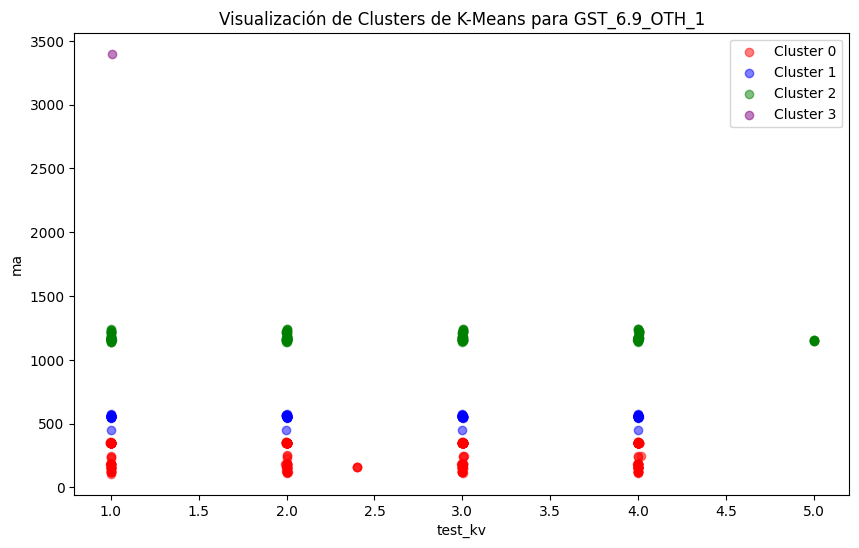

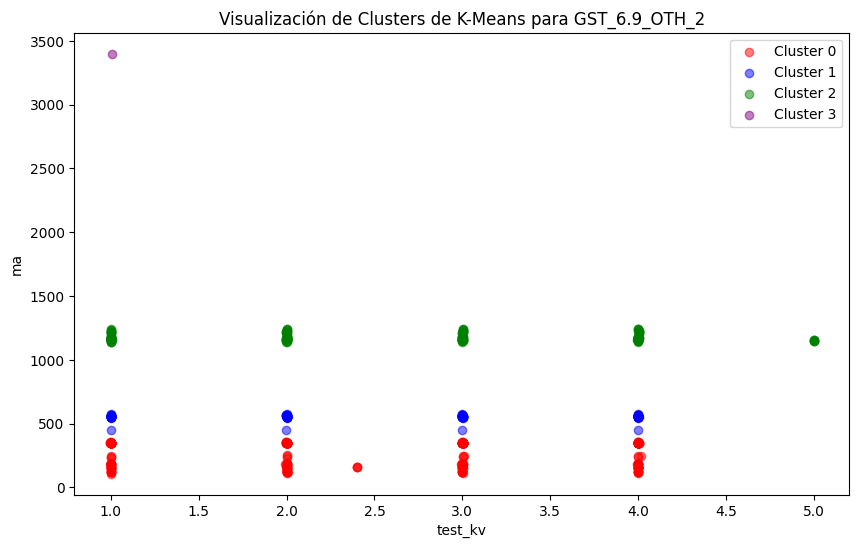

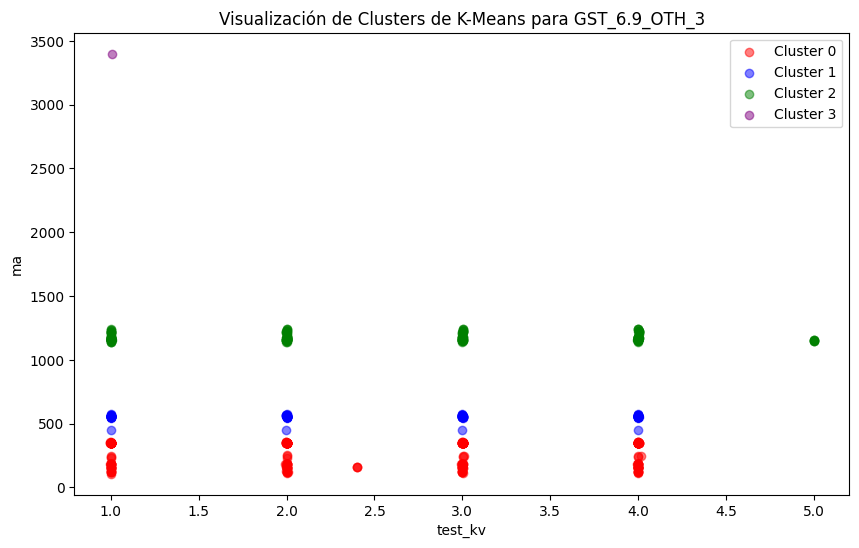

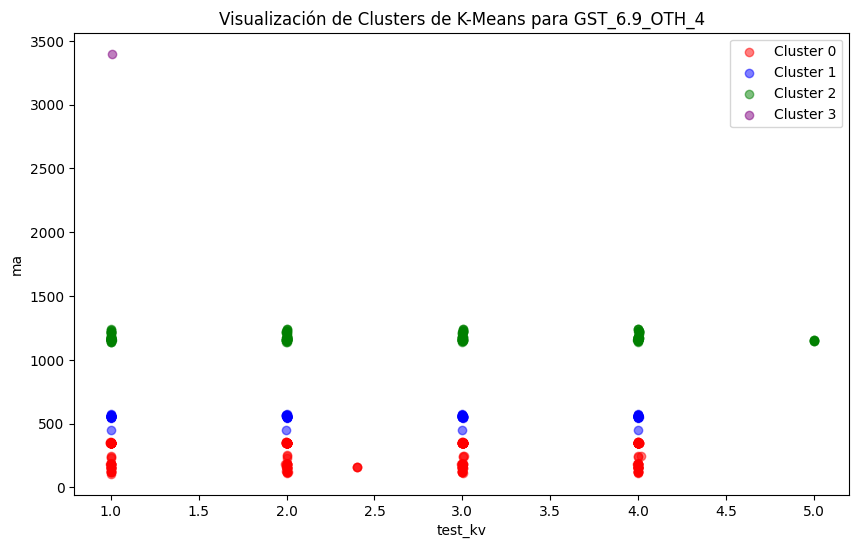

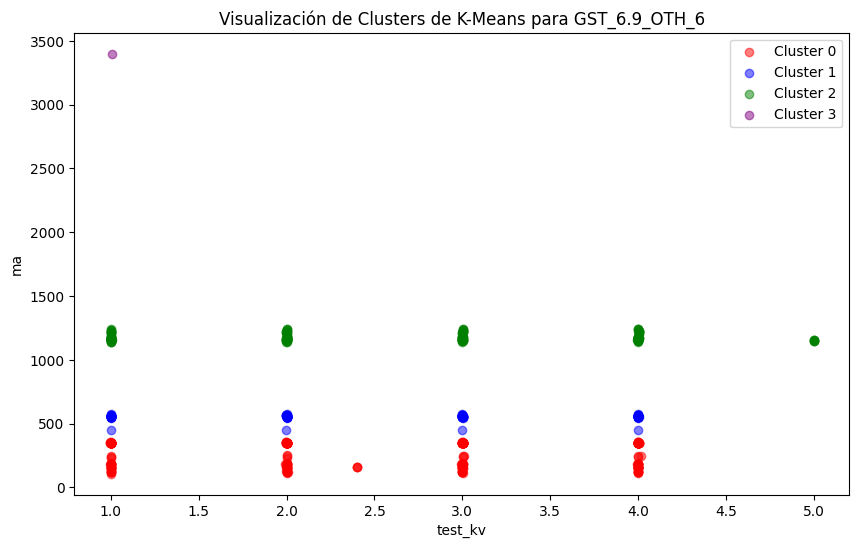

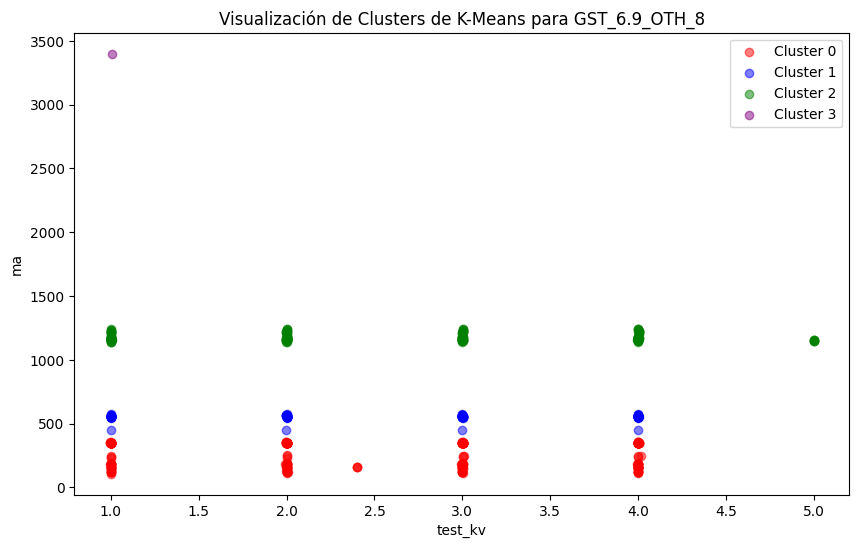

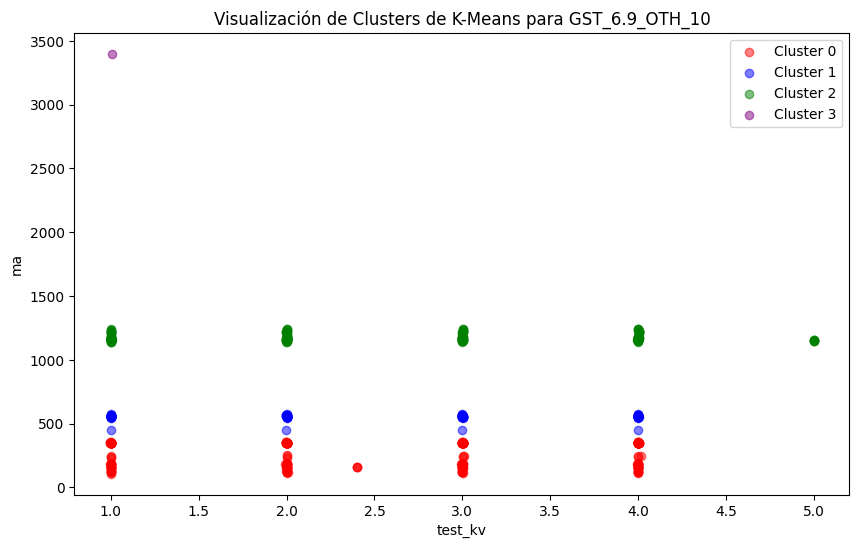

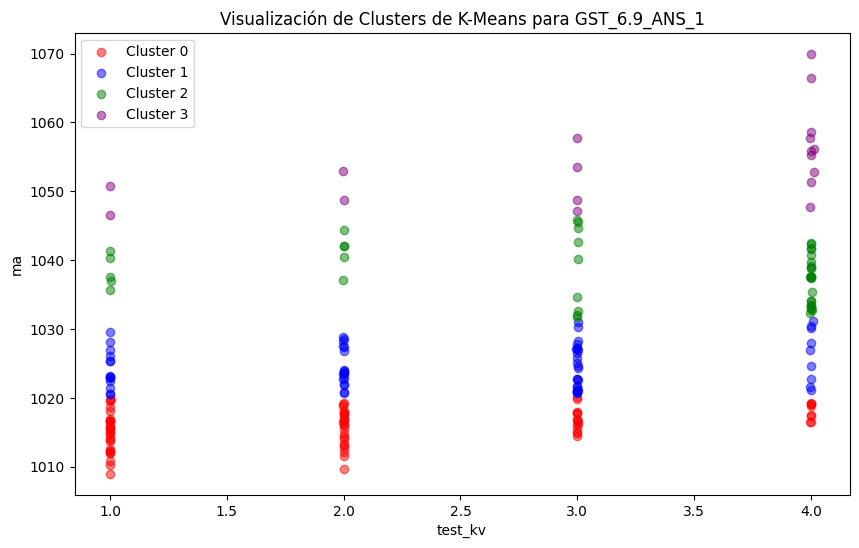

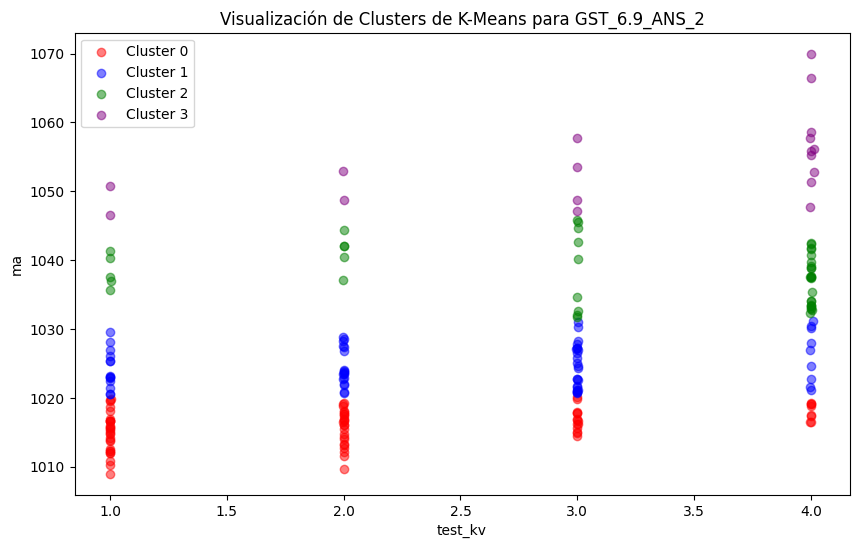

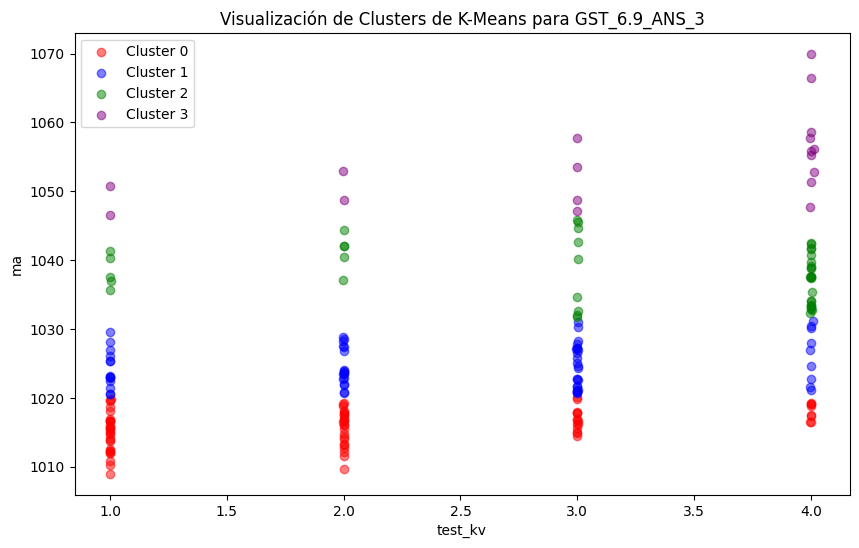

In [22]:
visualizar_kmeans_list(procesar_lista_objetos_test,10)

# **Gaussian Mixture Model (GMM)**

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split

def preparar_datos_gmm(ruta_csv):
    df = pd.read_csv(ruta_csv)
    X = df[['test_kv', 'ma']]  # Reemplazar con las columnas de características reales
    y = df['qual']  # La columna 'qual' como etiqueta
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

In [24]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

def entrenar_evaluar_gmm(X_train, y_train, X_test, y_test):
    gmm = GaussianMixture(n_components=len(y_train.unique()), random_state=42)
    gmm.fit(X_train, y_train)
    y_pred = gmm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [30]:
path_min= '/content/gdrive/MyDrive/Colab Notebooks/Proyecto_integradorA/df_con_familias.csv'

In [31]:
# Para GMM
X_train, X_test, y_train, y_test = preparar_datos_gmm(path_min)
accuracy_gmm = entrenar_evaluar_gmm(X_train, y_train, X_test, y_test)
print(f"Precisión del modelo GMM: {accuracy_gmm}")

Precisión del modelo GMM: 0.3761238761238761


# **Preparar los Datos para LSH**

In [32]:
!pip install datasketch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.8 MB/s eta 0:00:00


In [33]:
import pandas as pd
from datasketch import MinHash

def preparar_datos_lsh(ruta_csv):
    df = pd.read_csv(ruta_csv)
    minhashes = []

    for index, row in df.iterrows():
        m = MinHash()
        for col in df.columns:
            # Convertir cada valor a string y actualizar MinHash
            m.update(str(row[col]).encode('utf-8'))
        minhashes.append(m)

    return minhashes, df


In [34]:
from datasketch import MinHashLSH

def aplicar_lsh(minhashes):
    lsh = MinHashLSH(threshold=0.5, num_perm=128)
    for i, m in enumerate(minhashes):
        lsh.insert(f"row{i}", m)

    # Encontrar y devolver grupos de filas similares
    grupos = []
    for i, m in enumerate(minhashes):
        grupo = lsh.query(m)
        grupos.append(grupo)

    return grupos


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def entrenar_modelo_clasificacion(df, grupos):
    # Excluir la columna 'family' del conjunto de datos
    df = df.drop(['family'], axis=1)

    # Asignar grupos a los datos
    df['grupo'] = [next((i for i, grupo in enumerate(grupos) if f"row{index}" in grupo), -1) for index in df.index]
    y = df['grupo']
    X = df.drop(['grupo'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    modelo = RandomForestClassifier(random_state=42)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    return accuracy_score(y_test, y_pred)



In [39]:
# Preparar los datos y aplicar LSH
minhashes, df = preparar_datos_lsh(path_min)
grupos = aplicar_lsh(minhashes)

# Entrenar un modelo de clasificación
precisión = entrenar_modelo_clasificacion(df, grupos)
print(f"Precisión del modelo: {precisión}")


Precisión del modelo: 0.6483516483516484


He realizado un ejercicio de minería de datos utilizando técnicas avanzadas como Gaussian Mixture Model (GMM) y Locality-Sensitive Hashing (LSH) para clasificar un conjunto de datos. El objetivo era implementar un modelo de clasificación supervisada y evaluar su eficacia en la predicción correcta de las categorías de datos.

Inicialmente, apliqué el modelo GMM, una técnica que, aunque no es tradicionalmente usada para la clasificación supervisada, se adaptó para este propósito. Sin embargo, la precisión obtenida con GMM fue relativamente baja. Esto me llevó a explorar otras técnicas, concretamente la aplicación de LSH para agrupar datos similares, seguida de un modelo de clasificación supervisada basado en Random Forest. Esta combinación resultó en una mejora significativa, alcanzando una precisión de aproximadamente 64.8%. Esto indica que el modelo es capaz de predecir correctamente la clasificación de los datos en casi dos tercios de los casos.

# **Conclusiones y Recomendaciones:**

**Mejora en la Precisión:**

La precisión del 64.8% con el enfoque de LSH y Random Forest es una mejora significativa en comparación con la obtenida por el modelo GMM. Esto sugiere que la combinación de técnicas de hashing y modelos de clasificación supervisada puede ser más efectiva para este conjunto de datos.

**Potencial para Optimización:**

A pesar de la mejora, sigue habiendo espacio para optimizar el modelo. Esto podría incluir ajustes en los parámetros del modelo, selección de características más rigurosa, y aplicación de técnicas de preprocesamiento de datos.

**Evaluación Integral:**

Además de la precisión, se deben considerar otras métricas de rendimiento, especialmente en casos de distribución desigual de clases. La validación cruzada también puede proporcionar una evaluación más robusta.

**Exploración de Otros Modelos:**

Probar con otros modelos de clasificación supervisada y comparar los resultados podría ofrecer insights adicionales y posiblemente mejorar la precisión.

**Aplicabilidad del Modelo:**

Si bien el modelo actual tiene una precisión decente, su aplicabilidad práctica debe evaluarse en el contexto de los objetivos específicos y las necesidades de la aplicación.

En resumen, el ejercicio ha demostrado la utilidad de combinar técnicas de minería de datos para mejorar la clasificación supervisada, aunque destaca la necesidad de una optimización y evaluación continua para lograr un rendimiento óptimo del modelo.